In [1]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
import sys
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import loompy
import velocyto as vcy
import logging
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from statsmodels.nonparametric.smoothers_lowess import lowess
from scipy.interpolate import interp1d
import cytograph as cg
import loompy
import numpy as np
import scipy.sparse as sparse
import torch
from torch.distributions.poisson import Poisson
from torch.autograd import Variable
from torch.nn import MSELoss
from tqdm import trange
from types import SimpleNamespace
from matplotlib.colors import Normalize
from matplotlib.collections import LineCollection

2019-03-05 10:05:04,067 INFO: ERROR: failed to import igraph; some clustering methods will not work
/Users/stelin/anaconda53/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
2019-03-05 10:05:07,261 DEBUG: backend module://ipykernel.pylab.backend_inline version unknown


In [2]:
f = "/Users/stelin/build_20181213/L1_Subcortex.loom"

In [52]:
with loompy.connect(f) as ds:
    rnn = ds.col_graphs.RNN

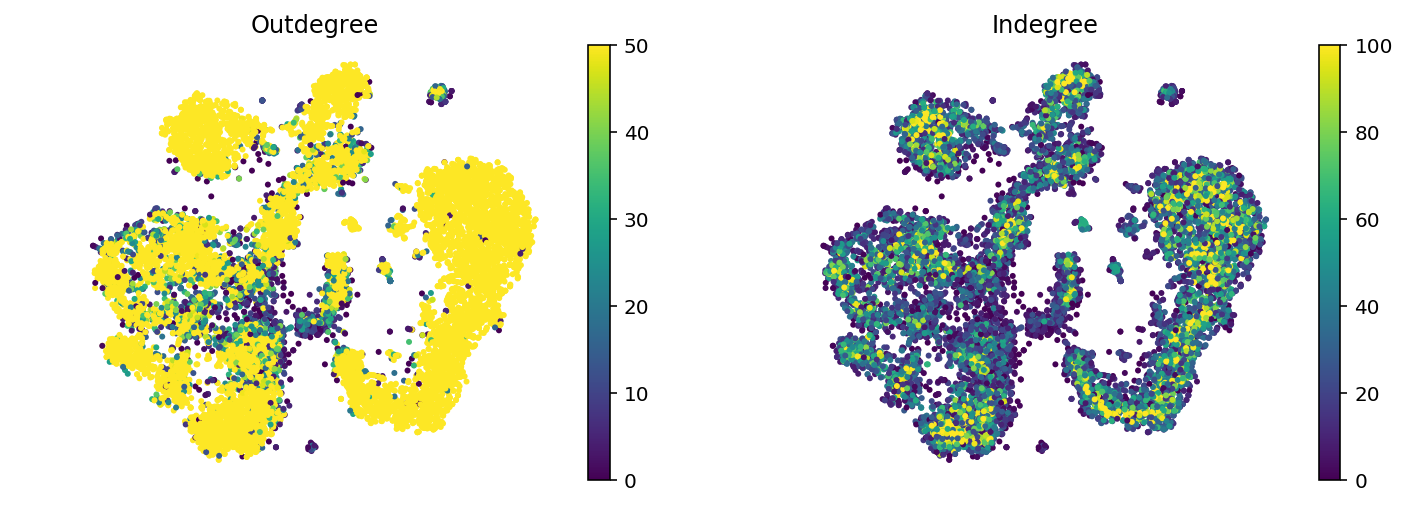

In [53]:
with loompy.connect(f) as ds:
    plt.figure(figsize=(12,4))
    plt.subplot(121)
    cax = plt.scatter(ds.ca.TSNE[:, 0], ds.ca.TSNE[:, 1], c=np.bincount(rnn.row), marker='.',lw=0)
    plt.colorbar(cax)
    plt.axis("off")
    plt.title("Outdegree")
    plt.subplot(122)
    cax = plt.scatter(ds.ca.TSNE[:, 0], ds.ca.TSNE[:, 1], c=np.bincount(rnn.col), marker='.',lw=0)
    plt.colorbar(cax)
    plt.axis("off")
    plt.title("Indegree")

In [3]:
class MidpointNormalize(Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

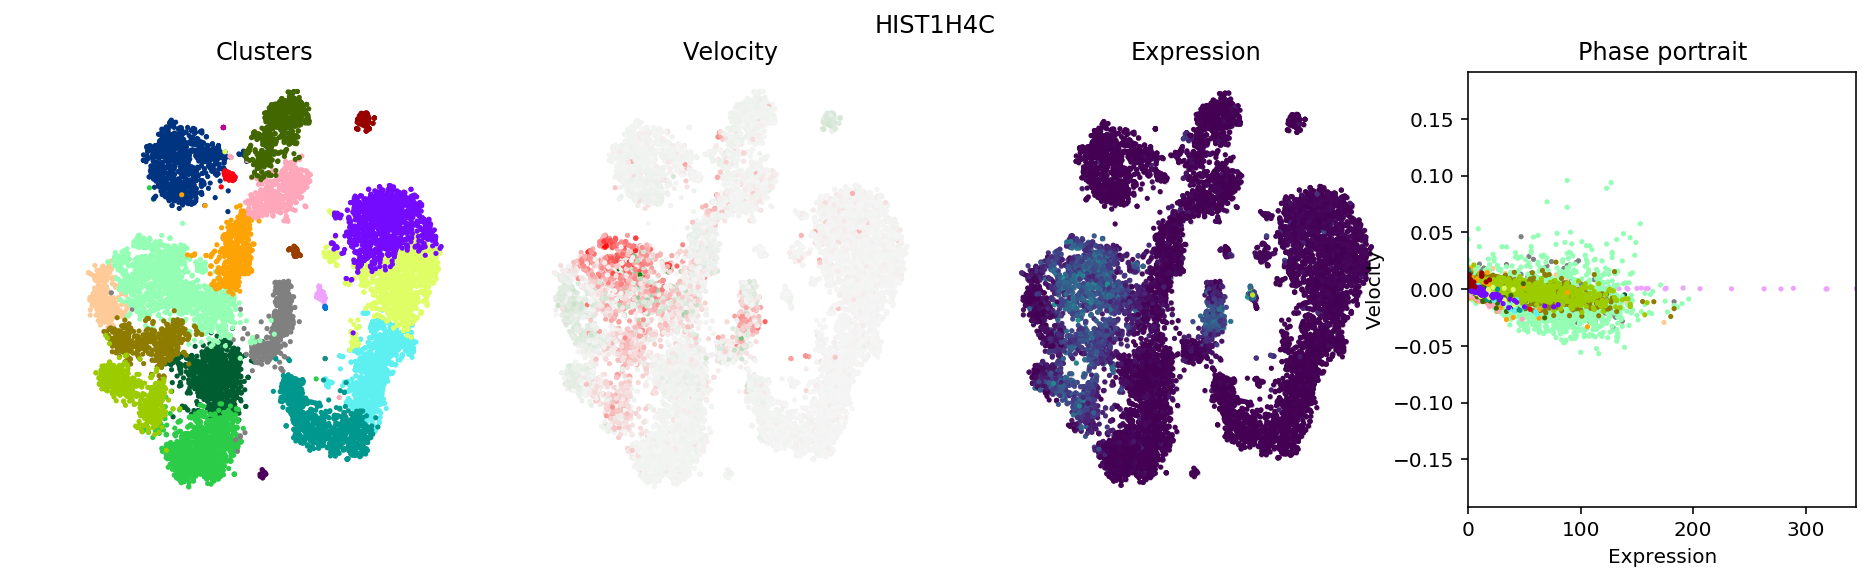

In [55]:

with loompy.connect(f) as ds:
    gene = "HIST1H4C"
    genes = ds.ra.Gene
    g = ds.ra.Gamma[genes == gene]
    s = ds["spliced"][ds.ra.Gene == gene, :][0]
    u = ds["unspliced_exp"][ds.ra.Gene == gene, :][0]
    v = ds["velocity"][ds.ra.Gene == gene, :][0]
    c = ds.ca.Clusters
    vcmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["red","whitesmoke","green"])
    norm = MidpointNormalize(midpoint=0)

    plt.figure(figsize=(16,4))
    plt.suptitle(gene)
    plt.subplot(141)
    plt.scatter(ds.ca.TSNE[:,0], ds.ca.TSNE[:,1], c=cg.colorize(c), marker='.',s=10)
    plt.title("Clusters")
    plt.axis("off")
    plt.subplot(142)
    plt.scatter(ds.ca.TSNE[:,0], ds.ca.TSNE[:,1], c=v,norm=norm, cmap=vcmap, marker='.',s=10)
    plt.title("Velocity")
    plt.axis("off")
    plt.subplot(143)
    plt.scatter(ds.ca.TSNE[:,0], ds.ca.TSNE[:,1], c="lightgrey", cmap="viridis", marker='.',s=10)
    plt.scatter(ds.ca.TSNE[:,0], ds.ca.TSNE[:,1], c=s, cmap="viridis", marker='.',s=10)
    plt.title("Expression")
    plt.axis("off")
    plt.subplot(144)
    plt.scatter(s, v, c=cg.colorize(c), marker='.',s=10)
    maxs = np.max(s)
    #plt.plot([0, maxs], [0, maxs*g], 'r--', color = 'b')
    plt.title("Phase portrait")
    plt.xlim(0, maxs)
    plt.ylim(-2*np.max(v), 2*np.max(v))
    plt.xlabel("Expression")
    plt.ylabel("Velocity")

In [7]:


def softplus(x, alpha):
    # This is a dampened version of softplus, which is much closer to relu than standard softplus
    # It also risks overflow...
    return torch.log(1 + torch.exp(alpha * x)) / alpha + 0.000001

class TimeDilationInference:
    def __init__(self, lr: float = 0.01, n_epochs: int = 100) -> None:
        self.lr = lr
        self.n_epochs = n_epochs
        self.losses: List[float] = []
        self.dt: np.ndarray = None
        self.b: np.ndarray = None
        self.g: np.ndarray = None

    def fit(self, ds: loompy.LoomConnection) -> None:
        # Load the data
        n_cells = ds.shape[1]
        self.nn = ds.col_graphs.RNN
        n_edges = self.nn.data.shape[0]
        selected = ds.ra.Selected == 1
        n_selected = selected.sum()
        g_data = ds.ra.Gamma[selected]
        s_data = np.empty((n_selected, n_cells))
        v_data = np.empty((n_selected, n_cells))
        r = 0
        for (_, _, view) in ds.scan(items=selected, axis=0, layers=["spliced_exp", "velocity"]):
            v_data[r:r + view.shape[0], :] = view.layers["velocity"][:, :]
            s_data[r:r + view.shape[0], :] = view.layers["spliced_exp"][:, :]
            r += view.shape[0]

        self.model = SimpleNamespace(
            # Inputs
            s = Variable(torch.tensor(s_data, dtype=torch.float), requires_grad=False),
            u = Variable(torch.tensor(u_data, dtype=torch.float), requires_grad=False),
            v = Variable(torch.tensor(v_data, dtype=torch.float), requires_grad=False),
            si = Variable(torch.tensor(s_data[:, self.nn.row], dtype=torch.float), requires_grad=False),
            sj = Variable(torch.tensor(s_data[:, self.nn.col], dtype=torch.float), requires_grad=False),
            ix = Variable(torch.tensor(self.nn.row, dtype=torch.long), requires_grad=False),
            jx = Variable(torch.tensor(self.nn.col, dtype=torch.long), requires_grad=False),
            # Model parameters, to be optimized
            b = Variable(torch.tensor(np.random.uniform(1, 1.01, size=n_selected), dtype=torch.float), requires_grad=False),
            dt = Variable(torch.tensor(np.random.normal(size=n_edges), dtype=torch.float), requires_grad=True),
            g = Variable(torch.tensor(g_data, dtype=torch.float), requires_grad=False)
        )
        #return self.epochs(self.n_epochs)
    
    def epochs(self, n_epochs: int, lr: float = None) -> None:
        if lr is not None:
            self.lr = lr
        m = self.model
        optimizer = torch.optim.SGD([m.dt], lr=self.lr)
        t = trange(n_epochs)

        for epoch in t:
            optimizer.zero_grad()
            #t.set_description("Zeroed gradients")
            ## Set up the computation graph for the log-likelihood
            # Estimate velocity given beta and gamma
            v = m.b.unsqueeze(1) * m.u - m.g.unsqueeze(1) * m.s
            #t.set_description("Estimated velocities")
            # Expand into vectors of velocities for source and target cells
            vi = v[:, m.ix]
            #t.set_description("Expanded vector i")
            vj = v[:, m.jx]
            #t.set_description("Expanded vector j")

            # Extrapolate from source to target; use softplus to prevent negative or zero values after extrapolation
            extrapolated_fw = softplus(m.si + m.dt * vi, 10)  # softplus prevents negative values for extrapolation
            #t.set_description("Extrapolated fw")
            # Calculate the MSE at the extrapolated value
            loss = MSELoss()(extrapolated_fw, m.sj)
            #t.set_description("Loss fw")
            # Extrapolate from target to source
            extrapolated_rev = softplus(m.sj - m.dt * vj, 10)
            #t.set_description("Extrapolated rev")
            # Add to the loss
            loss += MSELoss()(extrapolated_rev, m.si)
            #t.set_description("Loss rev")

            self.losses.append(float(loss))
            loss.backward()
            #t.set_description("backward")
            optimizer.step()
            #t.set_description("step")
            m.b.data.clamp_(min=0)
            #m.g.data.clamp_(min=0.001)
            t.set_description(f"loss={loss}")
            t.refresh()
    
        self.dt = m.dt.detach().numpy()
        self.b = m.b.detach().numpy()
        self.g = m.g.detach().numpy()
        #self.gt = m.gt.detach().numpy()
        return self

In [9]:
with loompy.connect(f) as ds:
    tdi = TimeDilationInference(lr=0.01)
    tdi.fit(ds)

In [10]:
tdi.epochs(2)

loss=0.00963693205267191: 100%|██████████| 2/2 [00:25<00:00, 12.62s/it]


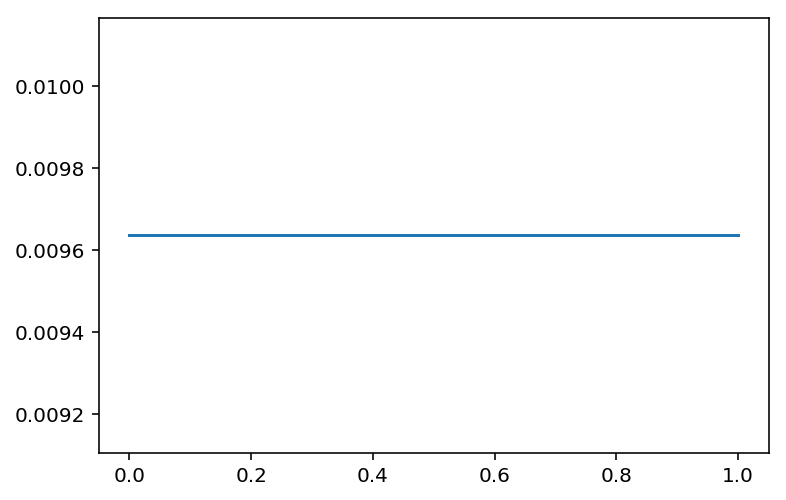

In [11]:
plt.plot(np.arange(len(tdi.losses)), tdi.losses)

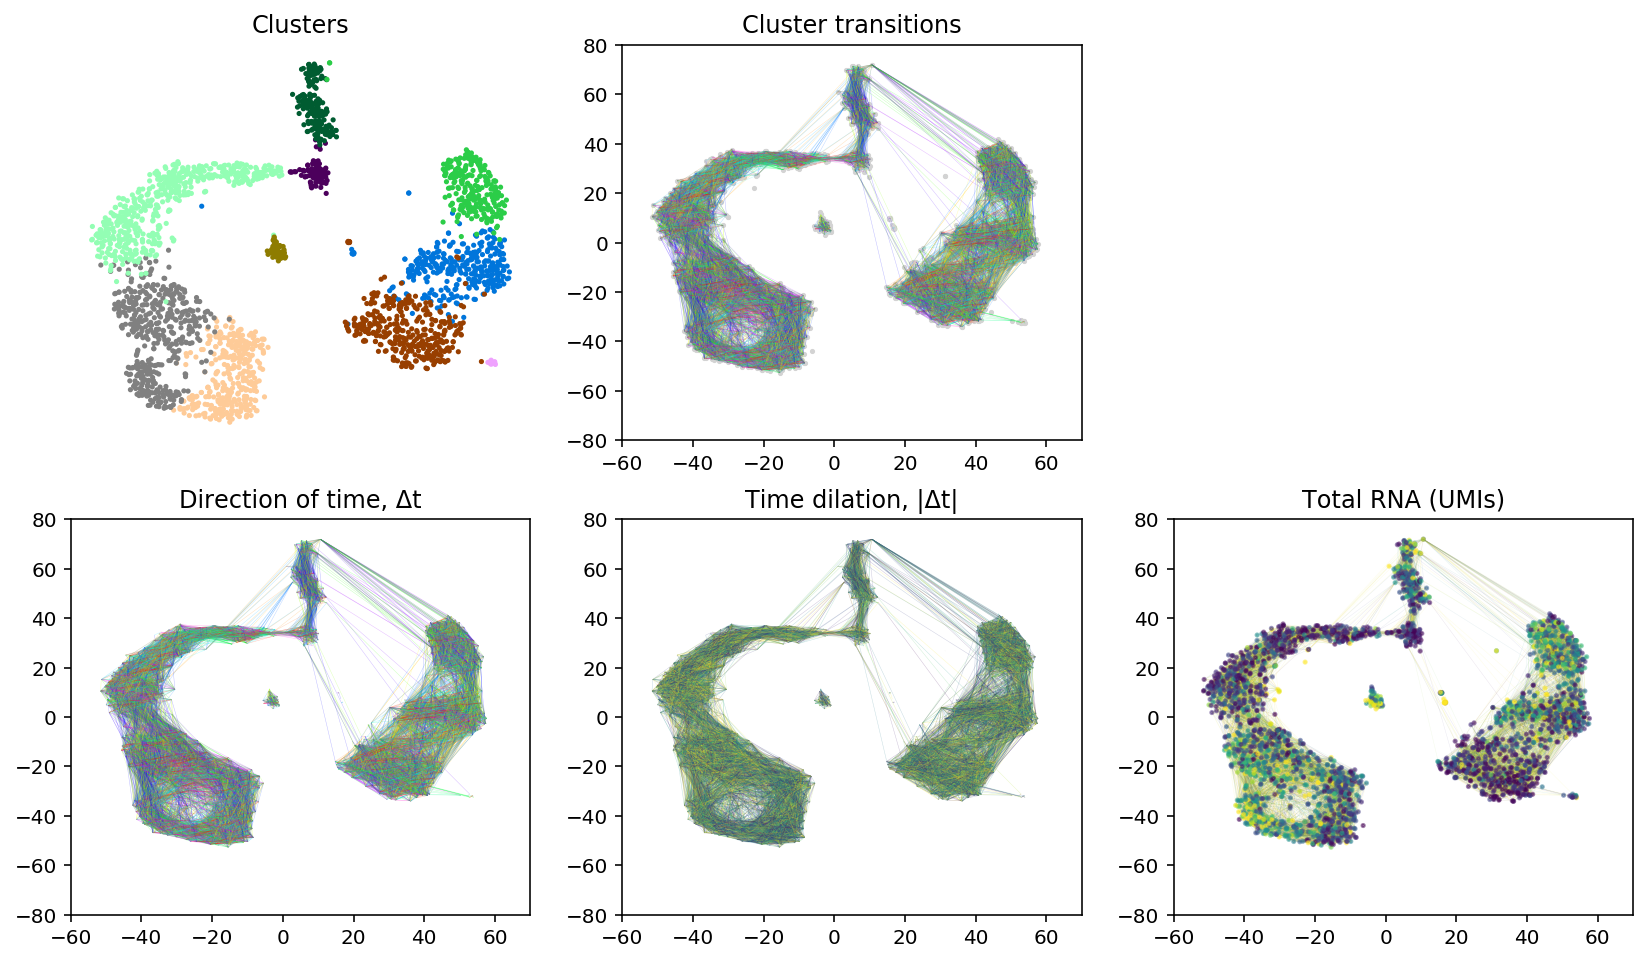

In [55]:

vcmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["magenta","whitesmoke","green"])
with loompy.connect(f) as ds:
    nn = tdi.nn
    (a, b, w) = (nn.row, nn.col, nn.data)
    longest = ds.ca.Clusters[a] != 93 # ds.ca.Clusters[b]
    w = w[longest]
    a = a[longest]
    b = b[longest]
    pos = ds.ca.TSNE
    plt.figure(figsize=(14,8))
    plt.subplot(231)
    plt.scatter(ds.ca.TSNE[:,0], ds.ca.TSNE[:,1], c=cg.colorize(ds.ca.Clusters), marker='.',s=10)
    plt.title("Clusters")
    plt.axis("off")
    ax = plt.subplot(232)
    dt = tdi.model.dt.detach().numpy()
    dt = dt[longest]
    deltas = pos[a] - pos[b]
    angles = np.arctan2(deltas[:,1], deltas[:,0]) + np.pi
    angles[dt < 0] = np.mod(angles[dt < 0] + np.pi, 2*np.pi)
    lc = LineCollection(zip(pos[a], pos[b]), linewidths=0.25, color=plt.cm.gist_rainbow(angles/6.28), alpha=0.25)
    ax.add_collection(lc)
    plt.scatter(ds.ca.TSNE[:,0], ds.ca.TSNE[:,1], c='lightgrey', marker='.',s=10)
    plt.xlim(-60,70)
    plt.ylim(-80, 80)
    plt.title("Cluster transitions")

    ax = plt.subplot(234)
    dt = tdi.model.dt.detach().numpy()
    dt = dt[longest]
    deltas = pos[a] - pos[b]
    angles = np.arctan2(deltas[:,1], deltas[:,0]) + np.pi
    angles[dt < 0] = np.mod(angles[dt < 0] + np.pi, 2*np.pi)
    lc = LineCollection(zip(pos[a], pos[b]), linewidths=0.25, zorder=0, color=plt.cm.gist_rainbow(angles/6.28), alpha=0.25)
    ax.add_collection(lc)
    plt.xlim(-60,70)
    plt.ylim(-80, 80)
    plt.title("Direction of time, Δt")
    ax = plt.subplot(235)
    dt = tdi.model.dt.detach().numpy()
    lc = LineCollection(zip(pos[a], pos[b]), linewidths=0.25, zorder=0, color=plt.cm.viridis(abs(dt)), alpha=0.25)
    ax.add_collection(lc)
    plt.xlim(-60,70)
    plt.ylim(-80, 80)
    plt.title("Time dilation, |Δt|")
    ax = plt.subplot(236)
    lc = LineCollection(zip(pos[a], pos[b]), linewidths=0.25, zorder=0, color=plt.cm.viridis(abs(dt)*2), alpha=0.1)
    ax.add_collection(lc)
    plt.scatter(ds.ca.TSNE[:,0], ds.ca.TSNE[:,1], c=ds.ca.TotalRNA, alpha=0.5, vmin=2071, vmax=4936, cmap="viridis", marker='.',s=10)
    plt.xlim(-60,70)
    plt.ylim(-80, 80)
    plt.title("Total RNA (UMIs)")

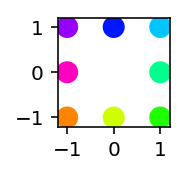

In [23]:
plt.figure(figsize=(1,1))
deltas = np.array([[1,0],[1, 1], [0, 1], [-1, 1], [-1, 0], [-1,-1], [0,-1], [1,-1]])
angles = np.arctan2(deltas[:,1], deltas[:,0]) + np.pi
#angles[0] = np.mod(angles[0] + 3.14, 6.28)
c = plt.cm.gist_rainbow(angles/6.28)
plt.scatter(x=deltas[:,0],y=deltas[:,1], c=c, s=100)
#plt.scatter(np.sin(angles), np.cos(angles), c=c, s=100,alpha=0.5)

## TODO: plot time dilation for a cell and all its neighbors

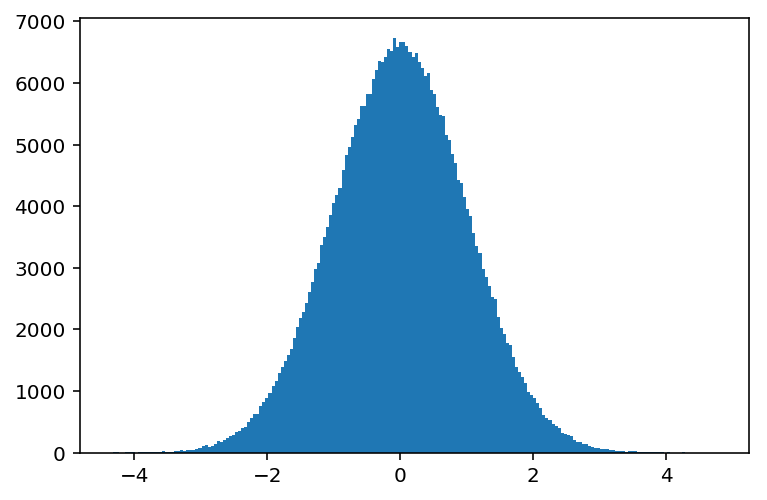

In [24]:
_=plt.hist(tdi.model.dt.detach().numpy(), bins=200)

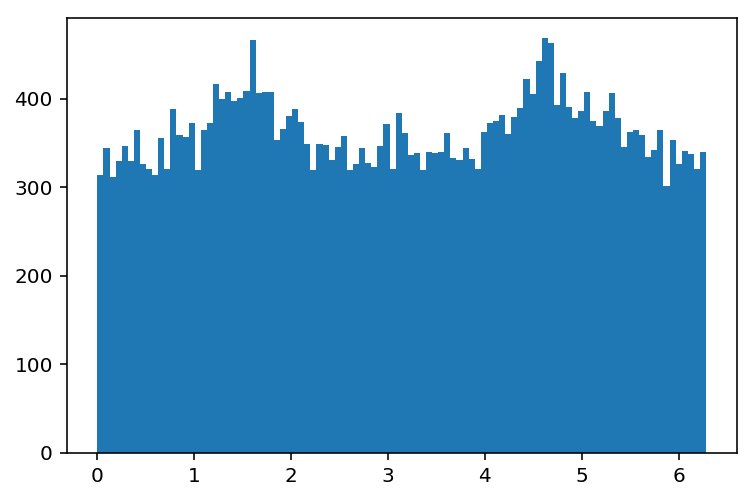

In [56]:
_=plt.hist(angles, bins=100)

(50,) (50,) (50,)


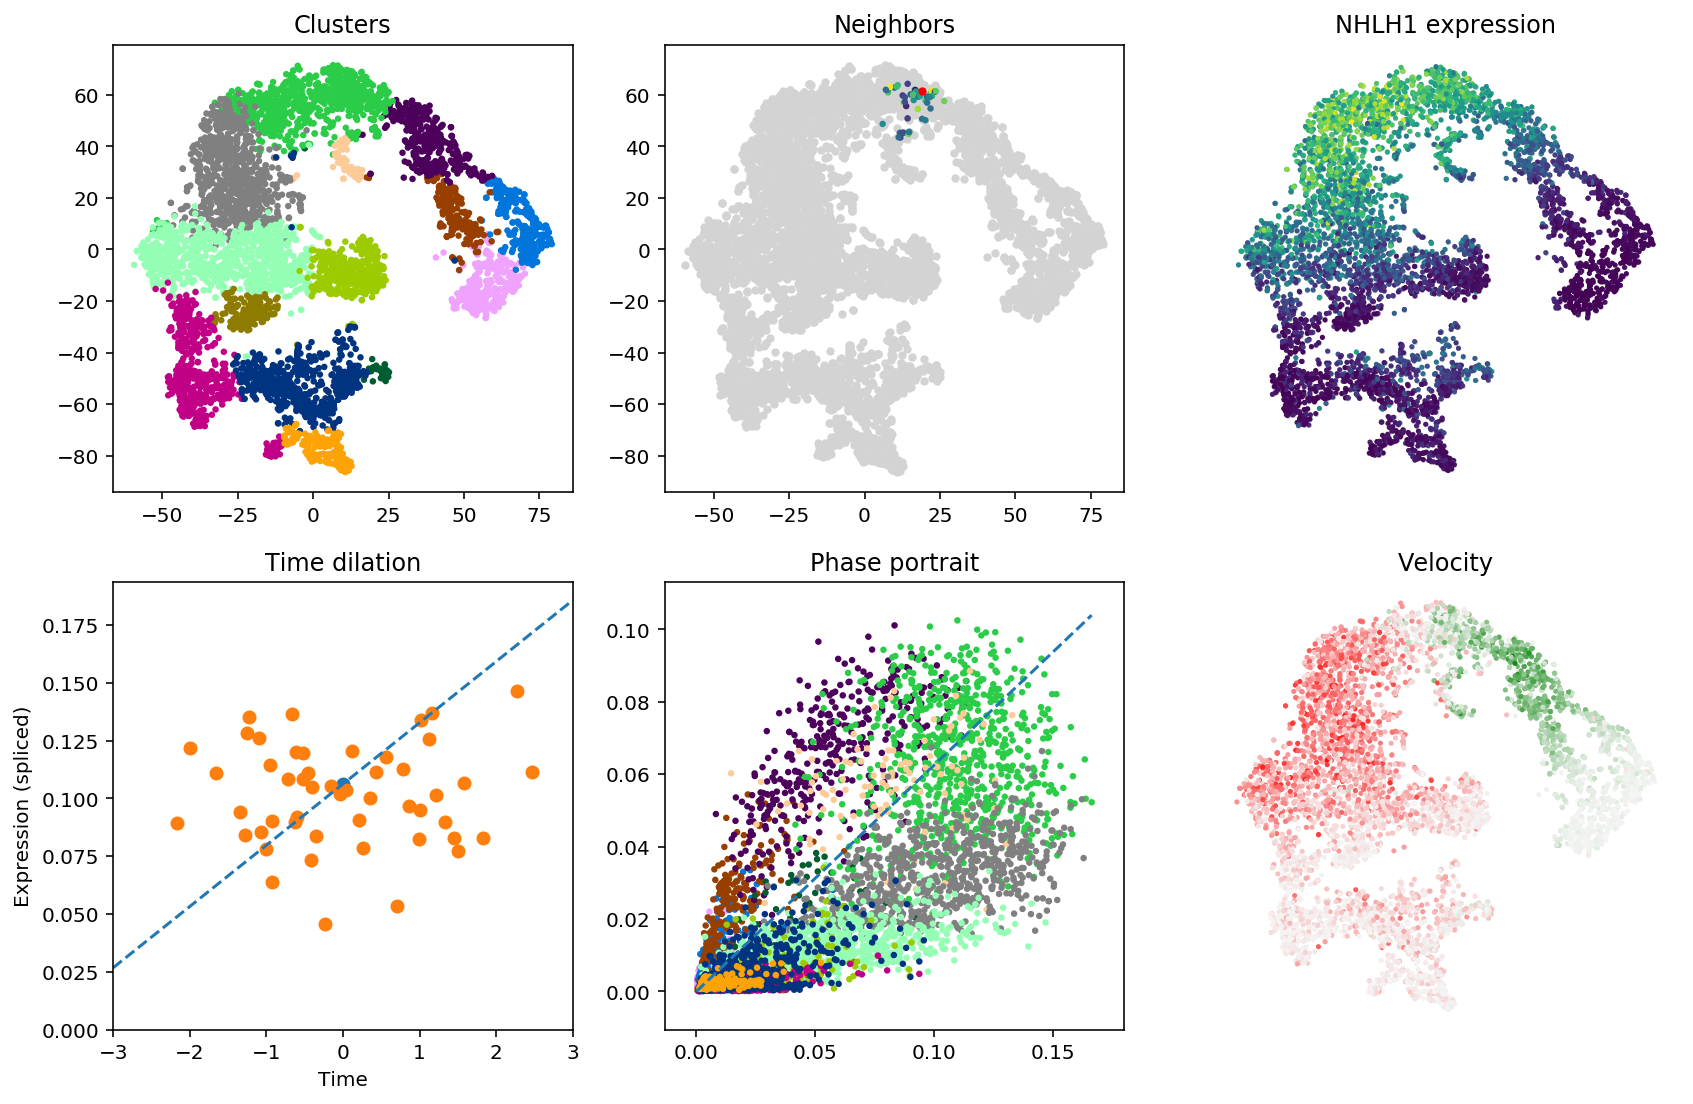

In [20]:
dt = tdi.model.dt.detach().numpy()
with loompy.connect(f) as ds:
    plt.figure(figsize=(14,14))
    gene1_name = "NHLH1"
    gene1 = np.where(ds.ra.Gene == gene1_name)[0]
    s = ds["spliced_exp"][gene1, :][0]
    v = ds["velocity"][gene1, :][0]
    rnn = tdi.nn
    cell1 = np.argsort(s)[-800]
    nns = rnn.col[np.where(rnn.row == cell1)]
    nn_edges = np.where((rnn.row == cell1) & (np.isin(rnn.col, nns)))[0]
    nn_times = dt[nn_edges]

    print(nn_times.shape, nn_edges.shape, nns.shape)
    plt.subplot(331)
    plt.scatter(ds.ca.TSNE[:,0], ds.ca.TSNE[:,1], c=cg.colorize(ds.ca.Clusters), marker='.', s=20)
    plt.title("Clusters")

    plt.subplot(332)
    plt.scatter(ds.ca.TSNE[:,0], ds.ca.TSNE[:,1], c='lightgrey', marker='.',s=40)
    plt.scatter(ds.ca.TSNE[nns,0], ds.ca.TSNE[nns,1], marker='.',s=20, c=nn_times)
    plt.scatter(ds.ca.TSNE[cell1,0], ds.ca.TSNE[cell1,1], marker='.',s=40, c='red')
    plt.title("Neighbors")
    
    plt.subplot(333)
    plt.scatter(ds.ca.TSNE[:,0], ds.ca.TSNE[:,1], c="lightgrey", cmap="viridis", marker='.',s=10)
    plt.scatter(ds.ca.TSNE[:,0], ds.ca.TSNE[:,1], c=s, cmap="viridis", marker='.',s=10)
    plt.title(gene1_name + " expression")
    plt.axis("off")
    
    plt.subplot(334)
    x1 = ds["spliced_exp"][gene1, cell1]
    plt.scatter(0, x1)
    v1 = ds["velocity"][gene1, cell1]
    plt.plot([-3, 3], [-3 * v1 + x1, 3 * v1 + x1], linestyle='dashed')
    x2 = ds["spliced_exp"][gene1, :][:, nns]
    plt.scatter(nn_times, x2)
    plt.xlim(-3, 3)
    plt.ylim(0, None)
    plt.title("Time dilation")
    plt.xlabel("Time")
    plt.ylabel("Expression (spliced)")
    
    plt.subplot(335)
    plt.scatter(ds["spliced_exp"][gene1, :], ds["unspliced_exp"][gene1, :], c=cg.colorize(ds.ca.Clusters), marker='.', s=20)
    max_s = np.max(ds["spliced_exp"][gene1, :])
    plt.plot([0,max_s], [0, max_s * ds.ra.Gamma[gene1]], linestyle="dashed")
    #plt.plot([0,max_s], [0, max_s * tdi.g[(ds.ra.Gene[ds.ra.Selected == 1] == gene1_name)]], linestyle="dashed")
    plt.title("Phase portrait")

    plt.subplot(336)
    norm = MidpointNormalize(midpoint=0)
    vcmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["red","whitesmoke","green"])
    
    plt.scatter(ds.ca.TSNE[:,0], ds.ca.TSNE[:,1], c=v, norm=norm, cmap=vcmap, marker='.',s=10)
    plt.title("Velocity")
    plt.axis("off")



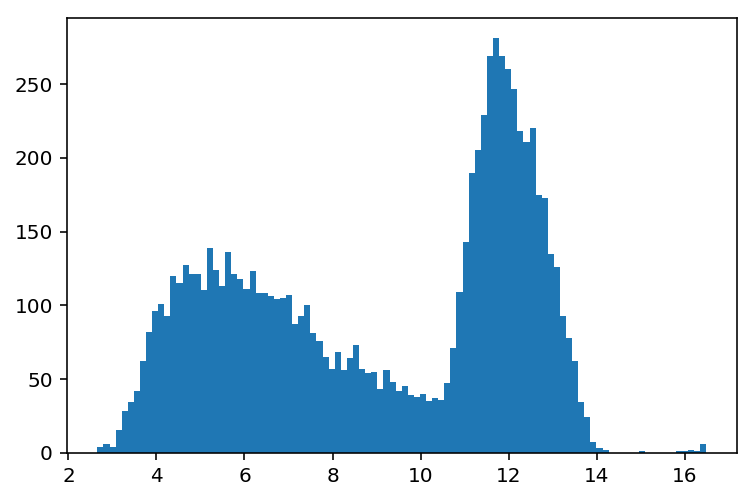

In [238]:
with loompy.connect("/Users/stelin/dh_20170213/L1_Cortex_8w_2.loom") as ds:
    plt.hist(-np.log2(ds.ca.HPF[:, 18]), bins=100)

In [ ]:
import ipyvolume as ipv
with loompy.connect(f) as ds:
    colors = cg.colorize(ds.ca.Clusters)
    x,y,z = umap3d[:,0], umap3d[:,1], umap3d[:,2]    
ipv.figure()
ipv.scatter(x, y, z, color=colors, size=1, marker="box")
#ipv.gcc()
def set_view(figure, framenr, fraction):
    ipv.view(fraction*360, (fraction - 0.5) * 180, distance=1)
#ipv.movie('wave.gif', set_view, fps=20, frames=2)
ipv.savefig('cerbellum_umap.png')
#ipv.gcc()

Output()

In [20]:
import ipyvolume as ipv
from sklearn.decomposition import PCA
import numpy as np
f = "/Users/stelin/build_20181213/L1_Cerebellum.loom"
with loompy.connect(f) as ds:
    colors = cg.colorize(ds.ca.Clusters)
    clusters = [5,6,7,8,24]
    cells = np.where(np.isin(ds.ca.Clusters, clusters))[0]
    rnn = ds.col_graphs.RNN
    edges = np.isin(rnn.row, cells) & np.isin(rnn.col, cells)
    (a, b) = (rnn.row[edges], rnn.col[edges]) 
    #sdata = ds["spliced_exp"][ds.ra.Selected == 1, :]
    #vdata = ds["velocity"][ds.ra.Selected == 1, :]
    s = sdata[:, cells].T
    v = vdata[:, cells].T
    pca_transformer = PCA(n_components=3).fit(np.log(s+1))
    pca = pca_transformer.transform(np.log(s+1))
    xpca = pca_transformer.transform(np.log(s + v + 1)) - pca
    x,y,z = pca[:,0], pca[:,1], pca[:,2]
    u,v,w = xpca[:,0], xpca[:,1], xpca[:,2]
    
selected = np.random.randint(0, 1000, 100)
ipv.figure()
quiver = ipv.quiver(x, y, z, u, v, w, color=colors[cells], size=3)

from ipywidgets import FloatSlider, ColorPicker, VBox, jslink
size = FloatSlider(min=0, max=30, step=0.1)
size_selected = FloatSlider(min=0, max=30, step=0.1)
color = ColorPicker()
color_selected = ColorPicker()
jslink((quiver, 'size'), (size, 'value'))
jslink((quiver, 'size_selected'), (size_selected, 'value'))
jslink((quiver, 'color'), (color, 'value'))
jslink((quiver, 'color_selected'), (color_selected, 'value'))
VBox([ipv.gcc(), size, size_selected, color, color_selected])

In [130]:
import ipyvolume as ipv

f = "/Users/stelin/build_20181213/L2_Cerebellum_Neural.loom"
#f = "/Users/stelin/dh_20170213/L1_Mouse_Forebrain_E9_11.loom"
with loompy.connect(f) as ds:
    colors = cg.colorize(ds.ca.Clusters)
    umap = ds.ca.UMAP3D
    x,y,z = umap[:,0], umap[:,1], umap[:,2]
    
ipv.figure()
ipv.scatter(x, y, z, color=colors, size=10, marker="point_2d")
ipv.gcc()



OSError: File '/Users/stelin/build_20181213/L2_Cerebellum_Neural.loom' not found

In [58]:
def project(a, b):
    return a @ (b / np.linalg.norm(b))
project(np.array([-1,2]), np.array([2,0]))

-1.0

ValueError: c of shape (32,) not acceptable as a color sequence for x with size 6947, y with size 6947

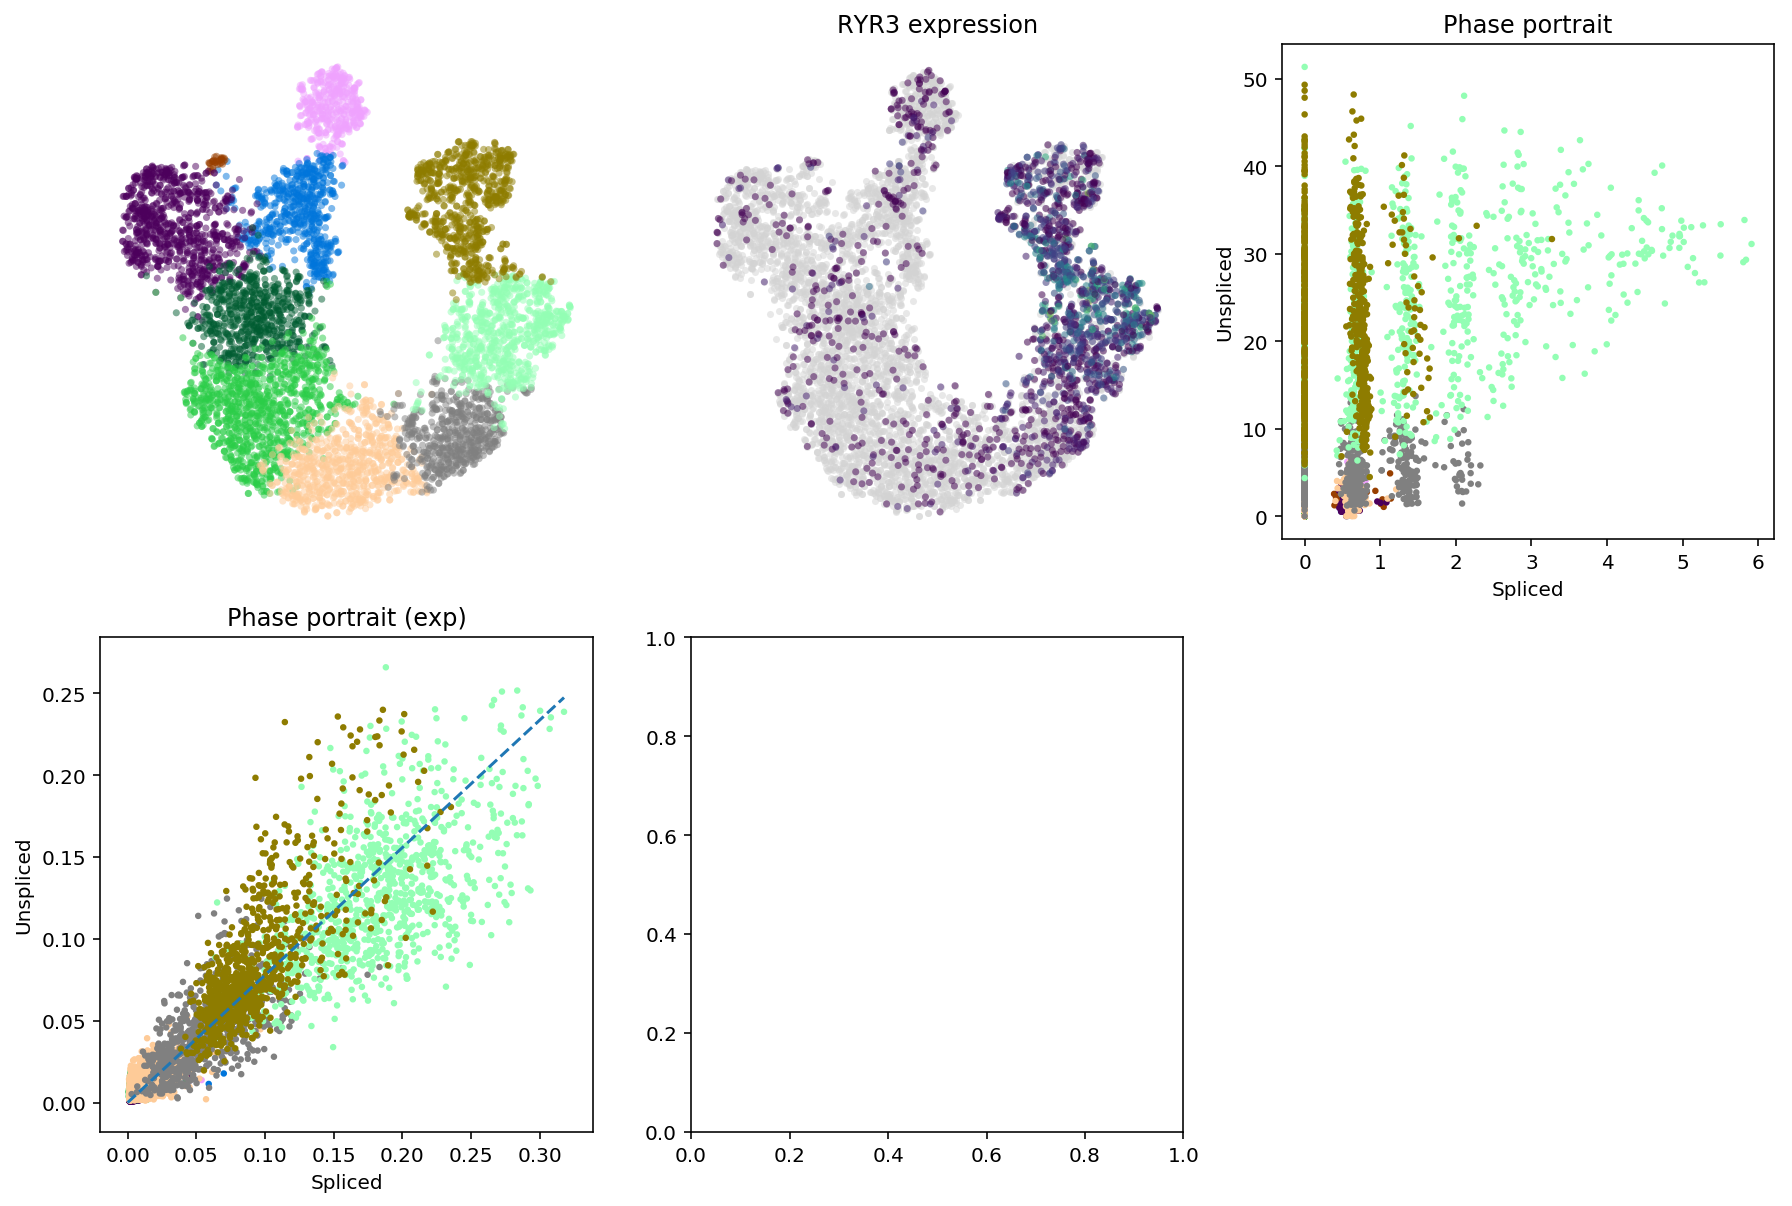

In [224]:
f = "/Users/stelin/build_20190211_local/L2_Cerebellum_Inhibitory.loom"
with loompy.connect(f) as ds:
    gene = "PAX2"
    gix = np.where(ds.ra.Gene == gene)[0][0]
    plt.figure(figsize=(15, 10))
    color = ds["pooled"][ds.ra.Gene==gene, :][0,:]
    cells = color > 0
    plt.subplot(231)
    plt.scatter(ds.ca.TSNE[:,0], ds.ca.TSNE[:,1], c=cg.colorize(ds.ca.Clusters), lw=0, marker='.', s=50, alpha=0.5)    
    plt.axis("off")
    plt.subplot(232)
    plt.scatter(ds.ca.TSNE[:,0], ds.ca.TSNE[:,1],c="lightgrey", lw=0, marker='.', s=50, alpha=0.5)    
    plt.scatter(ds.ca.TSNE[:,0][cells], ds.ca.TSNE[:,1][cells],c=color[cells], lw=0, marker='.', s=50, alpha=0.5)
    plt.title(gene + " expression")
    plt.axis("off")
    plt.subplot(233)
    knn = ds.col_graphs.KNN
    s = ds["spliced"][gix, :]
    u = ds["unspliced"][gix, :]
    s_knn = knn @ s
    u_knn = knn @ u
    plt.scatter(s_knn, u_knn, c=cg.colorize(ds.ca.Clusters), marker='.', s=20)
    plt.title("Phase portrait")
    plt.ylabel("Unspliced")
    plt.xlabel("Spliced")
    plt.subplot(234)
    s = ds["spliced_exp"][gix, :]
    u = ds["unspliced_exp"][gix, :]
    plt.scatter(s, u, c=cg.colorize(ds.ca.Clusters), marker='.', s=20)
    max_s = np.max(s)
    plt.plot([0,max_s], [0, max_s * ds.ra.Gamma[gix]], linestyle="dashed")
    plt.title("Phase portrait (exp)")
    plt.ylabel("Unspliced")
    plt.xlabel("Spliced")

    vcmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["red","whitesmoke","green"])
    norm = MidpointNormalize(midpoint=0)
    plt.subplot(235)
    v = ds["velocity"][gix, :]
    factor = 0
    #v_hpf = ds.ra.HPF[ds.ra.Selected == 1].T @ ds["velocity"][ds.ra.Selected == 1, :]
    plt.scatter(ds.ca.TSNE[:,0], ds.ca.TSNE[:,1],vmin=np.percentile(v_hpf[factor], 2),vmax=np.percentile(v_hpf[factor], 98), c=v_hpf[factor],norm=norm, cmap=vcmap, marker='.',s=10)
    plt.title(f"Velocity ({factor})")
    plt.axis("off")


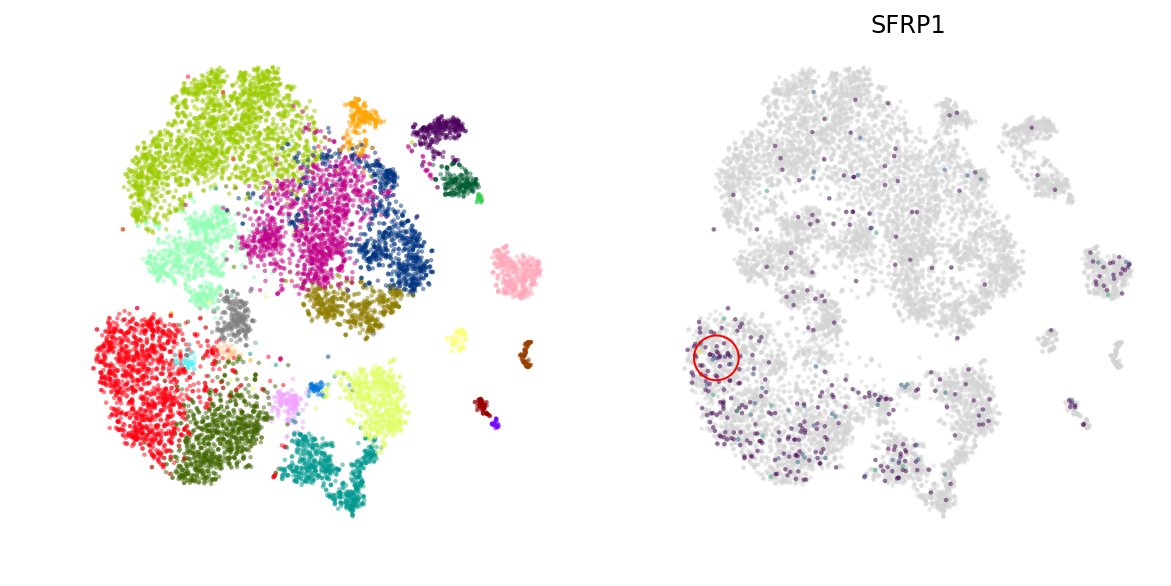

In [86]:
f = "/Users/stelin/build_20190211/L1_MidbrainVentral.loom"
with loompy.connect(f) as ds:
    cell = 9100
    gene = ds.ra.Gene[np.argsort(ds["enrichment"][:, cell])[-1]]
    gix = np.where(ds.ra.Gene == gene)[0][0]
    plt.figure(figsize=(15, 10))
    color = ds[ds.ra.Gene==gene, :][0,:]
    cells = color > 0
    plt.subplot(231)
    plt.scatter(ds.ca.TSNE[:,0], ds.ca.TSNE[:,1], c=cg.colorize(ds.ca.Clusters), lw=0, marker='.', s=20, alpha=0.5)    
    plt.axis("off")
    plt.subplot(232)
    plt.scatter(ds.ca.TSNE[:,0], ds.ca.TSNE[:,1],c="lightgrey", lw=0, marker='.', s=20, alpha=0.5)    
    plt.scatter(ds.ca.TSNE[:,0][cells], ds.ca.TSNE[:,1][cells],c=color[cells], lw=0, marker='.', s=20, alpha=0.5)
    plt.scatter(ds.ca.TSNE[cell, 0],ds.ca.TSNE[cell, 1],s=500,facecolors='none', edgecolors='r')
    plt.title(gene)
    plt.axis("off")
    

In [136]:
f = "/Users/stelin/build_20190211_local/L2_Cerebellum_Inhibitory.loom"
with loompy.connect(f) as ds:
    beta = ds.ra.HPF
    #velocity = ds["velocity"][ds.ra.Selected == 1, :]
    ds.ca.HPFVelocity = (beta[ds.ra.Selected == 1].T @ velocity).T.astype("float32")
    #ve = cg.VelocityEmbedding(data_source="HPF", velocity_source="HPFVelocity", embedding_name="UMAP", neighborhood_type="RNN", points_kind="cells")
    ve = cg.VelocityEmbedding(data_source="HPF", velocity_source="HPFVelocity", embedding_name="UMAP", neighborhood_type="radius", neighborhood_size=0.5, points_kind="grid", num_points=50, min_neighbors=5)
    v_embedding = ve.fit(ds)

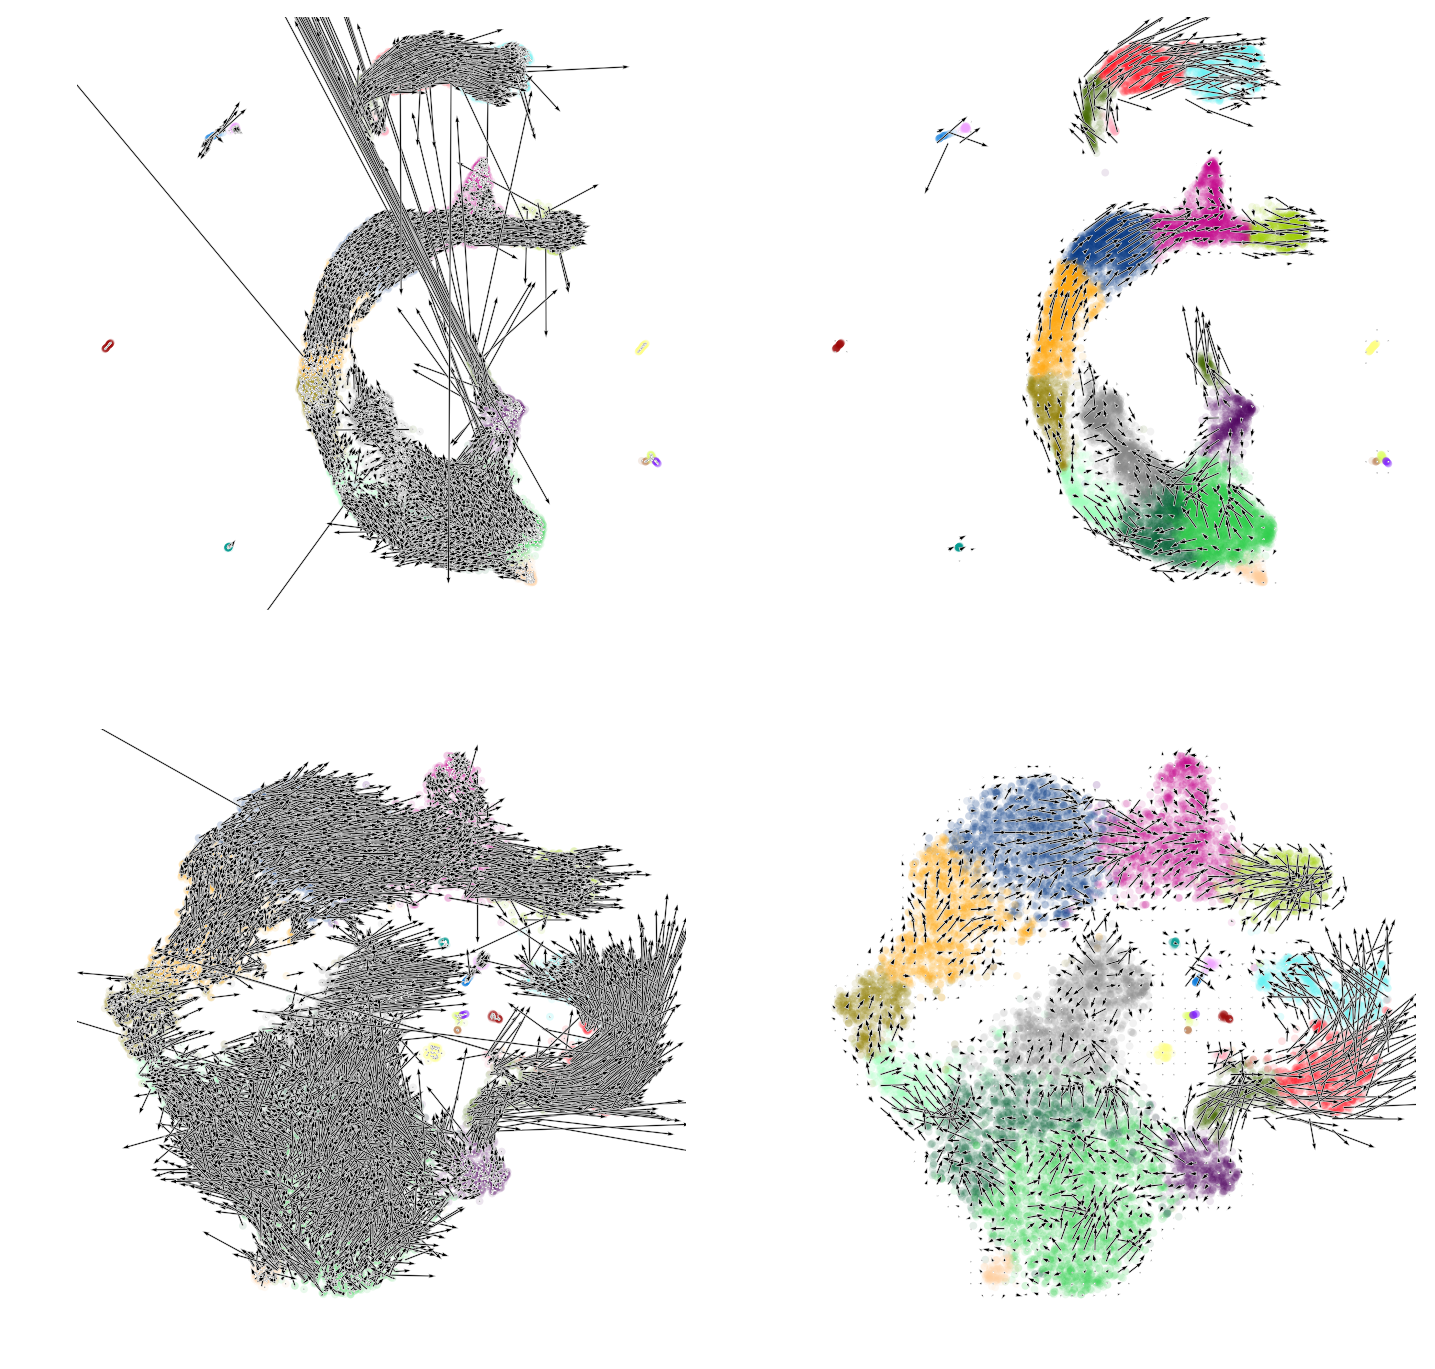

In [17]:
f = "/Users/stelin/build_20190211_local/L1_Cerebellum.loom"
with loompy.connect(f) as ds:
    plt.figure(figsize=(12, 12))
    plt.subplot(221)    
    xy = ds.ca.UMAP
    uv = ds.ca.UMAPVelocity
    plt.scatter(xy[:, 0], xy[:, 1], c=cg.colorize(ds.ca.Clusters), lw=0, s=15, alpha=0.1)
    plt.quiver(xy[:, 0], xy[:, 1], uv[:, 0], uv[:, 1], angles='xy', scale_units='xy', scale=2.5, edgecolor='white', facecolor="black", linewidth=.25)
    plt.axis("off")

    plt.subplot(222)
    xy = ds.attrs.UMAPVelocityPoints
    uv = ds.attrs.UMAPVelocity
    plt.scatter(ds.ca.UMAP[:, 0], ds.ca.UMAP[:, 1], c=cg.colorize(ds.ca.Clusters), lw=0, s=15, alpha=0.1)
    plt.quiver(xy[:, 0], xy[:, 1], uv[:, 0], uv[:, 1], angles='xy', scale_units='xy', scale=1, edgecolor='white', facecolor="black", linewidth=.25)
    plt.axis("off")

    plt.subplot(223)    
    xy = ds.ca.TSNE
    uv = ds.ca.TSNEVelocity
    plt.scatter(xy[:, 0], xy[:, 1], c=cg.colorize(ds.ca.Clusters), lw=0, s=15, alpha=0.1)
    plt.quiver(xy[:, 0], xy[:, 1], uv[:, 0], uv[:, 1], angles='xy', scale_units='xy', scale=2.5, edgecolor='white', facecolor="black", linewidth=.25)
    plt.axis("off")

    plt.subplot(224)
    xy = ds.attrs.TSNEVelocityPoints
    uv = ds.attrs.TSNEVelocity
    plt.scatter(ds.ca.TSNE[:, 0], ds.ca.TSNE[:, 1], c=cg.colorize(ds.ca.Clusters), lw=0, s=15, alpha=0.1)
    plt.quiver(xy[:, 0], xy[:, 1], uv[:, 0], uv[:, 1], angles='xy', scale_units='xy', scale=1, edgecolor='white', facecolor="black", linewidth=.25)
    plt.axis("off")

    plt.show()


In [1]:
import logging
from cytograph import tsne
import numpy as np
import loompy
main_layer = "pooled"
self_k = 50
f = "/Users/stelin/build_20190211_local/L1_Heart.loom-luigi-tmp-1128446680"
with loompy.connect(f) as ds:
    logging.info("TSNE using 'multinomial subspace' distance")
    subspace_genes_union = np.zeros(0, dtype="int")
    ds["subspace"] = "int16"
    logging.info("-- Computing subspace")
    for ix, selection, view in ds.scan(axis=1, layers=[main_layer, "enrichment_nn"]):
        n_genes = self_k * 2
        subspace_genes = np.sort(np.argsort(-view["enrichment_nn"][:, :], axis=0)[:n_genes, :], axis=0)
        data = view[main_layer][:, :]
        for i, s in enumerate(selection):
            # Negate the selected genes (we'll flip the sign of the whole matrix later)
            data[subspace_genes[:, i], s - ix] = -data[subspace_genes[:, i], s - ix]
        data = -data
        ds["subspace"][:, selection[0]: selection[-1] + 1] = data
        subspace_genes_union = np.union1d(subspace_genes_union, subspace_genes)
    logging.info("-- Loading subspace")
    subspace = np.zeros(shape=(subspace_genes_union.shape[0], ds.shape[1]), dtype="int16")
    for ix, selection, view in ds.scan(axis=1, layers=["subspace"]):
        subspace[:, selection[0]: selection[-1] + 1] = view["subspace"][subspace_genes_union, :]
    logging.info("-- Computing TSNE")
    ds.ca.TSNE_mns = tsne(subspace.T, metric="mns", radius=1)


2019-03-01 19:06:46,619 INFO: ERROR: failed to import igraph; some clustering methods will not work
/Users/stelin/anaconda53/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
2019-03-01 19:06:51,235 INFO: TSNE using 'multinomial subspace' distance
2019-03-01 19:06:51,353 INFO: -- Computing subspace
2019-03-01 19:07:12,292 INFO: -- Loading subspace
2019-03-01 19:07:15,168 INFO: -- Computing TSNE


AssertionError: All probabilities should be finite

2019-03-01 19:11:07,041 DEBUG: backend module://ipykernel.pylab.backend_inline version unknown


In [56]:
with loompy.connect(f) as ds:
    print(ds.ra.Gene[ds["subspace"][:,5] > 0])
    xy = ds.ca.TSNE_mns
    plt.figure(figsize=(7, 7))
    plt.scatter(xy[:, 0], xy[:, 1], c="lightgrey", lw=0, s=15, alpha=0.5)
    plt.axis("off")
    plt.show()

['TFPI' 'SELE' 'NRXN3' 'COL23A1' 'FOXC1' 'CALCRL' 'TIE1' 'NAV3' 'ADGRF5'
 'PTGS2' 'ITGA8' 'FXYD5' 'BIK' 'PROCR' 'DOK5' 'BMX' 'SALL1' 'LYL1' 'ENG'
 'SORCS1' 'CSF3' 'CCL2' 'NCOA7' 'ADGRG6' 'GMDS' 'NPR3' 'LEPR' 'ECE1'
 'COLEC11' 'NRP2' 'OLFM3' 'TEK' 'CDKN1A' 'MT2A' 'CD93' 'SAT1' 'APOC1'
 'PLVAP' 'RAMP2' 'DCLK1' 'POSTN' 'CLDN10' 'NT5E' 'EDNRB' 'RAPGEF5' 'IL33'
 'IER3' 'PRCP' 'BMPR1B' 'CPNE8' 'LRIG3' 'CDH11' 'HMCN1' 'SLC27A3' 'ADAM12'
 'LRRC4C' 'PCDH15' 'PITPNC1' 'UNC5D' 'ERG' 'NBL1' 'NTNG1' 'ADAMTS9' 'EMCN'
 'BMPER' 'SOX17' 'BAALC' 'FZD6' 'CTHRC1' 'TMEM100' 'TMEM88' 'NPR1' 'LDB2'
 'RND1' 'SNCG' 'CLEC14A' 'F2R' 'ZNF467' 'BACE2' 'OPCML' 'CCSER1' 'F8'
 'FAM43A' 'GJA4' 'AKR1C3' 'ENPP1' 'SMOC1' 'ARHGAP26-AS1' 'AC017101.1'
 'GNA14-AS1' 'ADAMTS9-AS1' 'LINC01896' 'MMP28' 'CD24' 'AC142391.1']


NameError: name 'plt' is not defined

In [2]:
def corrcoef(y, X):
    # Efficiently calculate the correlation between vector y and rows of matrix X
    Xm = np.reshape(np.mean(X,axis=1),(X.shape[0],1))
    ym = np.mean(y)
    r_num = np.sum((X-Xm)*(y-ym),axis=1)
    r_den = np.sqrt(np.sum((X-Xm)**2,axis=1)*np.sum((y-ym)**2))
    r = r_num/r_den
    return r

In [3]:
def cell_cycle_correlations(ds):
    cca = cg.CellCycleAnnotator(ds)
    data = ds["pooled"][:, :]
    seed = cca.g1
    seed_data = data[np.isin(ds.ra.Gene, seed), :]
    #corrs = []
    #for i in trange(seed_data.shape[0]):
    #    corrs.append(corrcoef(seed_data[i, :], data))
    #corrs_g1 = np.array(corrs)
    corrs_g1 = corrcoef(seed_data.sum(axis=0), data)
    
    seed = cca.s
    seed_data = data[np.isin(ds.ra.Gene, seed), :]
    #corrs = []
    #for i in trange(seed_data.shape[0]):
    #    corrs.append(corrcoef(seed_data[i, :], data))
    #corrs_s = np.array(corrs)
    corrs_s = corrcoef(seed_data.sum(axis=0), data)
    
    seed = cca.g2m
    seed_data = data[np.isin(ds.ra.Gene, seed), :]
    #corrs = []
    #for i in trange(seed_data.shape[0]):
    #    corrs.append(corrcoef(seed_data[i, :], data))
    #corrs_g2m = np.array(corrs)
    corrs_g2m = corrcoef(seed_data.sum(axis=0), data)
    
    return (corrs_g1, corrs_s, corrs_g2m)


In [80]:
pools = ["Subcortex", "MidbrainDorsal", "Cerebellum", "Diencephalon", "Hypothalamus"]
corrs = {}
for pool in pools:
    f = f"/Users/stelin/build_20190211/L1_{pool}.loom"
    with loompy.connect(f) as ds:
        logging.info(pool)
        corrs[pool] = cell_cycle_correlations(ds)

f = f"/Users/stelin/build_20190211_local/L1_Heart.loom"
with loompy.connect(f) as ds:
    logging.info("Heart")
    corrs["Heart"] = cell_cycle_correlations(ds)

2019-03-04 13:27:34,976 INFO: Subcortex
/Users/stelin/anaconda53/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys
/Users/stelin/anaconda53/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
2019-03-04 13:31:29,349 INFO: MidbrainDorsal
2019-03-04 13:32:00,916 INFO: Cerebellum
2019-03-04 13:35:32,491 INFO: Diencephalon
2019-03-04 13:38:32,588 INFO: Hypothalamus
2019-03-04 13:39:52,927 INFO: Heart


In [88]:
n = 500
counts = np.zeros(shape=(33538, len(pools), 3))
pools = ["Subcortex", "MidbrainDorsal", "Cerebellum", "Diencephalon", "Hypothalamus"]
for i, pool in enumerate(pools):
    f = f"/Users/stelin/build_20190211/L1_{pool}.loom"
    with loompy.connect(f) as ds:
        ordering = np.argsort(ds.ra.Gene)
        genes = ds.ra.Gene[ordering]
        for phase in [0,1,2]:
            top = np.argsort(-corrs[pool][phase][ordering])[:n]
            counts[top, i, phase] = 1
found = np.sum(counts, axis=(1,2))
brain_genes = np.sort(genes[found > 2])

f = f"/Users/stelin/build_20190211_local/L1_Heart.loom"
with loompy.connect(f) as ds:
    ordering = np.argsort(ds.ra.Gene)
    genes = ds.ra.Gene[ordering]
    for phase in [0,1,2]:
        top_heart = np.argsort(-corrs["Heart"][phase][ordering])[:6*n]
    heart_genes = genes[top_heart]

cc_genes = np.intersect1d(heart_genes, brain_genes)
print(cc_genes.shape)
cc_genes

(768,)


array(['ABHD3', 'AC016205.1', 'AC073529.1', 'AC084033.3', 'AC087632.1',
       'AC091057.6', 'AC097534.2', 'AC099850.2', 'AC135586.2', 'ACAA2',
       'ACADM', 'ACP1', 'ACTL6A', 'ACYP1', 'ADCY3', 'ADD3', 'ADK', 'AHCY',
       'AKIRIN2', 'AKR7A2', 'AL359513.1', 'AL449266.1', 'AL513165.2',
       'ANAPC11', 'ANLN', 'ANP32A', 'ANP32B', 'ANP32E', 'AP001347.1',
       'APOLD1', 'ARHGAP11A', 'ARHGEF39', 'ARID1A', 'ARL6IP1', 'ARL6IP6',
       'ARMC1', 'ARPP19', 'ASF1B', 'ASPM', 'ASRGL1', 'ATAD2', 'ATAD5',
       'ATP1B3', 'AURKA', 'AURKB', 'BANF1', 'BARD1', 'BAZ1A', 'BAZ1B',
       'BIRC5', 'BLM', 'BORA', 'BRCA1', 'BRCA2', 'BRD8', 'BRIP1', 'BTG3',
       'BUB1', 'BUB1B', 'BUB3', 'C11orf58', 'C19orf48', 'C1orf112',
       'C1orf35', 'C21orf58', 'C5orf34', 'CACYBP', 'CALM2', 'CAMTA1',
       'CARHSP1', 'CBX1', 'CBX3', 'CBX5', 'CCAR1', 'CCDC14', 'CCDC167',
       'CCDC18', 'CCDC34', 'CCDC77', 'CCNA1', 'CCNA2', 'CCNB1', 'CCNB2',
       'CCNE2', 'CCNF', 'CCT4', 'CCT5', 'CDC20', 'CDC25B', 'CDC25C',

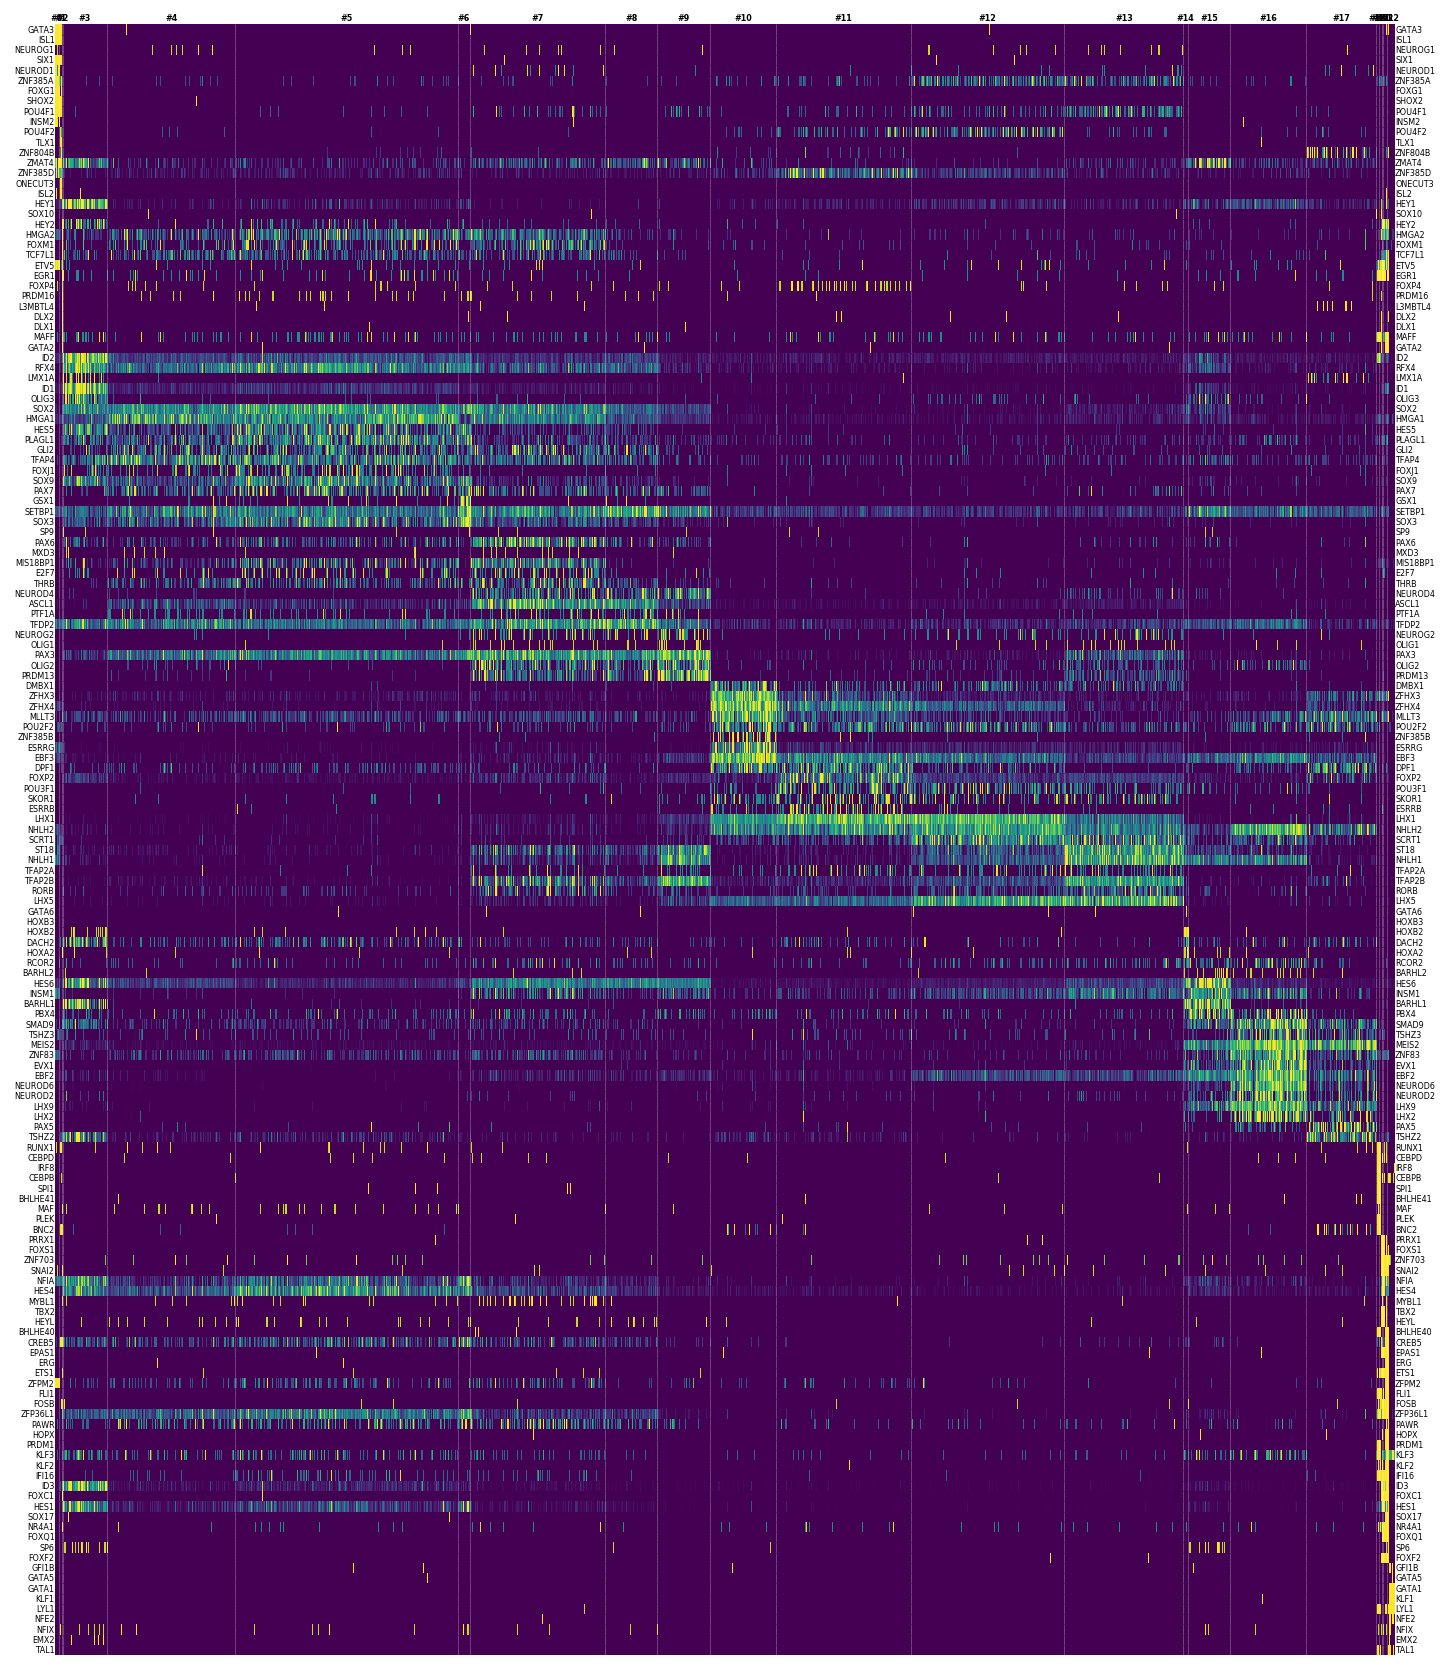

In [62]:
def plot_TF_heatmap(ds: loompy.LoomConnection, dsagg: loompy.LoomConnection, layer: str = "pooled", out_file: str = None) -> None:
    enrichment = dsagg["enrichment"][:, :]
    enrichment = enrichment[np.isin(dsagg.ra.Gene, cg.TFs_human), :]
    genes = dsagg.ra.Gene[np.isin(dsagg.ra.Gene, cg.TFs_human)]
    genes = genes[np.argsort(-enrichment, axis=0)[:10, :]].T  # (n_clusters, n_genes)
    genes = np.unique(genes)  # 1d array of unique genes, sorted
    n_genes = len(genes)
    n_clusters = dsagg.shape[1]
    clusterborders = np.cumsum(dsagg.col_attrs["NCells"])
    
    # Now sort the genes by cluster enrichment
    top_cluster = []
    for g in genes:
        top_cluster.append(np.argsort(-dsagg["enrichment"][ds.ra.Gene == g, :][0])[0])
    genes = genes[np.argsort(top_cluster)]
    
    plt.figure(figsize=(12, n_genes // 10))
    for ix, g in enumerate(genes):
        ax = plt.subplot(n_genes, 1, ix + 1)
        gix = np.where(ds.ra.Gene == g)[0][0]
        vals = ds[layer][gix, :]
        vals = vals / (np.percentile(vals, 99) + 0.1)
        ax.imshow(np.expand_dims(vals, axis=0), aspect='auto', cmap="viridis", vmin=0, vmax=1)
        ax.set_frame_on(False)
        ax.set_xticks([])
        ax.set_yticks([])
        text = plt.text(0, 0.9, g, horizontalalignment='right', verticalalignment='top', transform=ax.transAxes, fontsize=4, color="black")
        text = plt.text(1.001, 0.9, g, horizontalalignment='left', verticalalignment='top', transform=ax.transAxes, fontsize=4, color="black")
    
        # Draw border between clusters
        if n_clusters > 2:
            tops = np.vstack((clusterborders - 0.5, np.zeros(clusterborders.shape[0]) - 0.5)).T
            bottoms = np.vstack((clusterborders - 0.5, np.zeros(clusterborders.shape[0]) + 0.5)).T
            lc = LineCollection(zip(tops, bottoms), linewidths=0.5, color='white', alpha=0.25)
            ax.add_collection(lc)

        if ix == 0:
            # Cluster IDs
            labels = ["#" + str(x) for x in np.arange(n_clusters)]
            if "ClusterName" in ds.ca:
                labels = dsagg.ca.ClusterName
            for ix in range(0, clusterborders.shape[0]):
                left = 0 if ix == 0 else clusterborders[ix - 1]
                right = clusterborders[ix]
                text = plt.text(left + (right - left) / 2, -1.5, labels[ix], horizontalalignment='center', verticalalignment='top', fontsize=4, color="black", weight="bold")
            

    plt.subplots_adjust(hspace=0)
    #plt.close()

with loompy.connect("/Users/stelin/build_20190211_local/L1_Cerebellum.loom") as ds:
    with loompy.connect("/Users/stelin/build_20190211_local/L1_Cerebellum.agg.loom") as dsagg:
        plot_TF_heatmap(ds, dsagg)



In [100]:
import math
math.ceil(9 / 10)

1

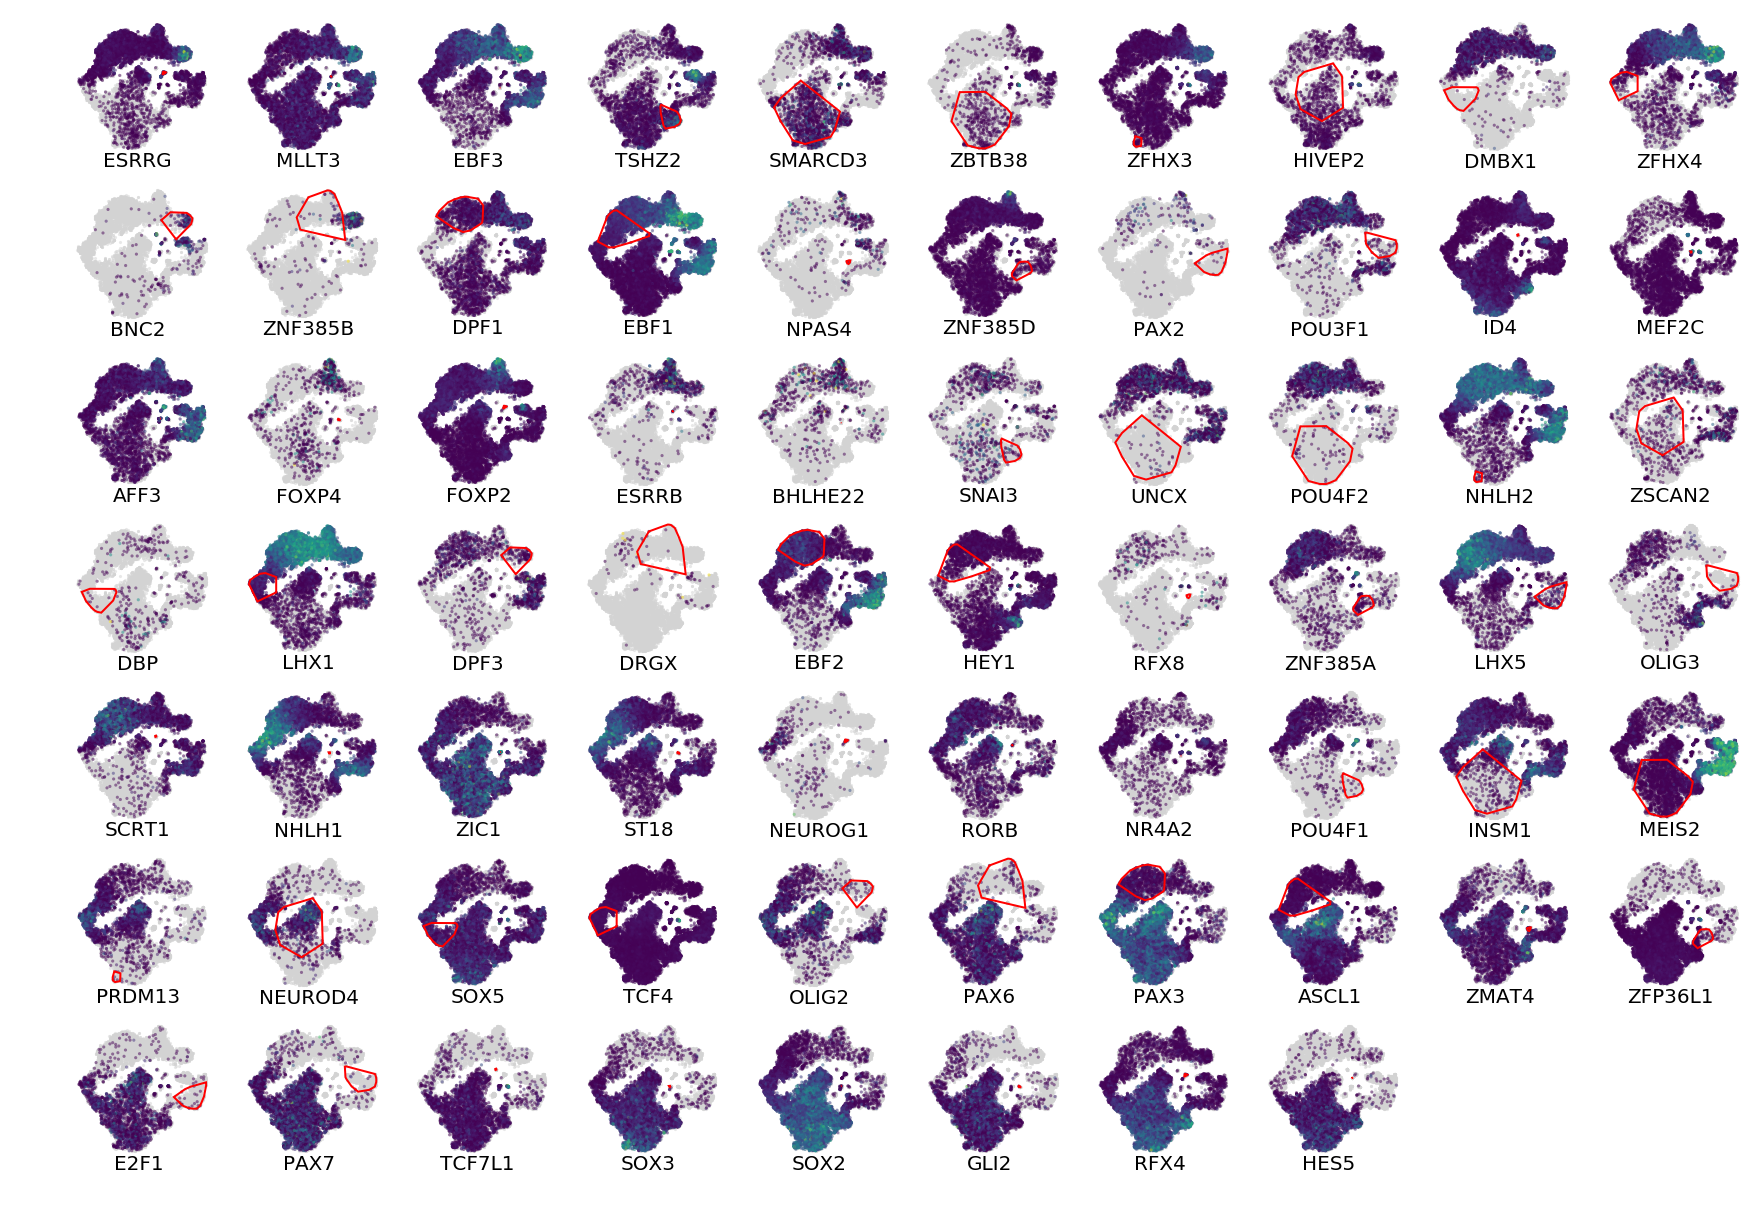

In [134]:
import math
from scipy.spatial import ConvexHull

def mad(points, thresh=2.5):
    """
    Returns a boolean array with True if points are outliers and False 
    otherwise.

    Parameters:
    -----------
        points : An numobservations by numdimensions array of observations
        thresh : The modified z-score to use as a threshold. Observations with
            a modified z-score (based on the median absolute deviation) greater
            than this value will be classified as outliers.

    Returns:
    --------
        mask : A numobservations-length boolean array.

    References:
    ----------
        Boris Iglewicz and David Hoaglin (1993), "Volume 16: How to Detect and
        Handle Outliers", The ASQC Basic References in Quality Control:
        Statistical Techniques, Edward F. Mykytka, Ph.D., Editor. 
    """
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation

    return modified_z_score > thresh

f = "/Users/stelin/build_20190211_next/L1_Cerebellum.loom"
with loompy.connect(f) as ds:
    genes = ["ESRRG", "MLLT3", "EBF3", "TSHZ2", "SMARCD3", "ZBTB38", "ZFHX3", "HIVEP2", "DMBX1", "ZFHX4", "BNC2", "ZNF385B", "DPF1", "EBF1", "NPAS4", "ZNF385D", "PAX2", "POU3F1", "ID4", "MEF2C", "AFF3", "FOXP4", "FOXP2", "ESRRB", "BHLHE22", "SNAI3", "UNCX", "POU4F2", "NHLH2", "ZSCAN2", "DBP", "LHX1", "DPF3", "DRGX", "EBF2", "HEY1", "RFX8", "ZNF385A", "LHX5", "OLIG3", "SCRT1", "NHLH1", "ZIC1", "ST18", "NEUROG1", "RORB", "NR4A2", "POU4F1", "INSM1", "MEIS2", "PRDM13", "NEUROD4", "SOX5", "TCF4", "OLIG2", "PAX6", "PAX3", "ASCL1", "ZMAT4", "ZFP36L1", "E2F1", "PAX7", "TCF7L1", "SOX3", "SOX2", "GLI2", "RFX4", "HES5"]
    clusters = np.mod(np.arange(len(genes)), ds.ca.Clusters.max())
    n_cols = 10
    n_rows = math.ceil(len(genes) / 10)
    plt.figure(figsize=(15, 1.5 * n_rows))
    for i, gene in enumerate(genes):
        plt.subplot(n_rows, n_cols, i+1)
        color = ds["pooled"][ds.ra.Gene == gene, :][0,:]
        cells = color > 0
        plt.scatter(ds.ca.TSNE[:,0], ds.ca.TSNE[:,1],c="lightgrey", lw=0, marker='.', s=10, alpha=0.5)    
        plt.scatter(ds.ca.TSNE[:,0][cells], ds.ca.TSNE[:,1][cells],c=color[cells], lw=0, marker='.', s=10, alpha=0.5)
        points = ds.ca.TSNE[ds.ca.Clusters == clusters[i], :]
        points = points[~mad(points), :]
        hull = ConvexHull(points)
        plt.fill(points[hull.vertices,0], points[hull.vertices,1], edgecolor="red", lw=1, fill=False)
        plt.text(0, ds.ca.TSNE[:,1].min()*1.05, gene, color="black", fontsize=10, horizontalalignment="center", verticalalignment="top")
        plt.axis("off")

In [126]:
clusters

array([0, 1])

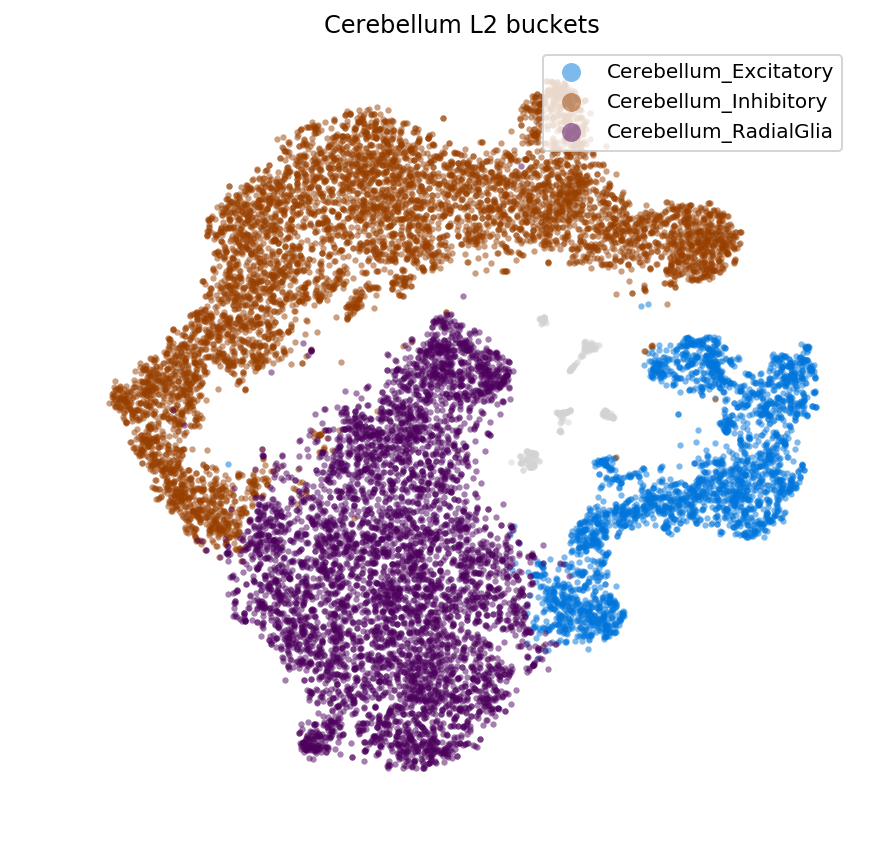

In [89]:
f = "/Users/stelin/build_20190211_next/L1_Cerebellum.loom"
with loompy.connect(f) as ds:
    fig = plt.figure(figsize=(7, 7))
    colors = cg.colorize(np.unique(ds.ca.Bucket))
    for ix, bucket in enumerate(np.unique(ds.ca.Bucket)):
        cells = ds.ca.Bucket == bucket
        plt.scatter(ds.ca.TSNE[cells,0], ds.ca.TSNE[cells,1], c=("lightgrey" if bucket == "" else colors[ix]), label=bucket, lw=0, marker='.', s=40, alpha=0.5)
        plt.axis("off")
        plt.title("Cerebellum L2 buckets")
    plt.legend(markerscale=3, loc="upper right")